# Sentiment Analysis 

In [148]:
from __future__ import print_function
import sys
import csv
import numpy as np
from numpy import exp, array, random, dot
import pandas as pd
import nltk
import spacy
import tensorflow as tf
import sklearn
from sklearn.model_selection import StratifiedKFold
import en_core_web_sm
import vaderSentiment
from gensim.models import KeyedVectors
import keras
from keras import layers
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences 
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
from keras_tqdm import TQDMNotebookCallback
from IPython import display
from keras.preprocessing.sequence import pad_sequences 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import numpy as np
import fastText
import h5py
sid = SentimentIntensityAnalyzer()

The identification of sentiment in text is an important field of study, it usually involves detecting whether a piece of text expresses a POSITIVE, a NEGATIVE, or a NEUTRAL sentiment; the sentiment can be general or about a specific topic, e.g., a person, a product, or an event.

Sentiment analysis has been part of the international workshop on Semantic Evaluation ([SemEval](https://en.wikipedia.org/wiki/SemEval)) for multiple years ([2016](http://anthology.aclweb.org/S/S16/S16-1001.pdf), [2017](http://www.aclweb.org/anthology/S17-2088)).

You task is to implement a neural network that predicts sentiment (POSITIVE, NEGATIVE, NEUTRAL) for a given text.

In the following sections, we provide the dataset preperation, a basic model, training and evaluation.


## Dataset

We include only reviews with 1,3 and 5 star ratings, where: 
* 1 is considered negative
* 3 is considered neutral
* 5 is considered positive

All reviews with rating 2,4 are not included in our dataset.


### Loading the data

In [242]:
#Create df with only 1,3,5 ; convert 2,4 to 1,5
#dfTest =pd.read_csv("tweetTrainingContext.csv", header=None)
#dfTest.drop(0, axis=1, inplace=True)
#dfTest = dfTest[dfTest[2] != 1]
#dfTest = dfTest[dfTest[2] != -1]
#dfTest.loc[dfTest[2] == 2, 2] = 5
#dfTest.loc[dfTest[2] == 1, 2] = 5
#dfTest.loc[dfTest[2] == -2, 2] = 1
#dfTest.loc[dfTest[2] == -1, 2] = 1
#dfTest.loc[dfTest[2] == 0, 2] = 3
##dfTest[2].sample(n=43, replace=True, random_state=1)
#print (Counter(dfTest[2]))
#dfTest.columns=['subject','label','body']
#dfTest.to_csv("tweetTrainingContextFilter2.csv")

#LOAD TRAINING DATA
#spread of data
#{3: 12993, 5: 1020, 1: 299})|
#dfTrain = pd.read_csv("tweetTrainingContextFilter.csv")
#Show dfTrain dist.
#dfTrain
#print (Counter(dfTrain['label']))

#Recreate df after downsampling
dfTrain = pd.read_csv("tweetTrainingContextFilter2.csv")
df3= dfTrain[dfTrain.label == 3]
df3=df3[:3697]
df1=dfTrain[dfTrain.label == 1]
df5=dfTrain[dfTrain.label == 5]
df5=df5[:3697]
dfTrain = df1.append(df3, ignore_index=True)
dfTrain= dfTrain.append(df5, ignore_index=True)
print (Counter(dfTrain['label']))

Counter({1: 3697, 3: 3697, 5: 3697})


The number of reviews is originally not equally distributed among the ratings, so we downsampled the reviews so that there is the same number for each rating. The discarded reviews are picked at random.

### Word Embeddings and Features

To convert text to vector space, we use [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) where words from the vocabulary are mapped to vectors of real numbers.

Multiple versions of the word embeddings have already been implemented, we use Facebook's [FastText](https://research.fb.com/fasttext/) library.

We trained our word embeddings on English wikipedia.

In [243]:
#load and save vector in quick load format
#en_model = KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec")
#en_model.save("wikiModel")

#RUN THIS: Load Models
twitterModel = KeyedVectors.load("twitterModel_1000000")
wikiModel = KeyedVectors.load("wikiModel")
#Prove model is loaded
#words = []

#for word in wikiModel.vocab:
#    words.append(word)

#number of words in vector
#print("Number of Tokens: {}".format(len(words)))

# Printing out the dimension of a word vector 
#print("Dimension of a word vector: {}".format(

#    len(wikiModel[words[0]])

#))

# Print out the vector of a word 
#print("Vector components of a word: {}".format(

#    wikiModel[words[0]]

#))

# Finding out similar words [default= top 10]
#find_similar_to = 'Clinton'
#for similar_word in wikiModel.similar_by_word(find_similar_to):

#    print("Word: {0}, Similarity: {1:.2f}".format(

#        similar_word[0], similar_word[1]

#    ))
#for similar_word in twitterModel.similar_by_word(find_similar_to):

#    print("Word: {0}, Similarity: {1:.2f}".format(

#        similar_word[0], similar_word[1]

#    ))



In [244]:
#CHANGED sequence length from 100 to 50
MAX_SEQUENCE_LENGTH = 40
#EMBEDDING_DIM = wikiModel.dim
#dimension of wikiModel
EMBEDDING_DIM = 300
#print(EMBEDDING_DIM)

#Consider creating vocabulary from wiki
vocabulary = dict()
inverse_vocabulary = ['PADDING']
sequences = []
for text in dfTrain.body:
    text = text.split()
    text_sequence = []
    for word in text:
        if word not in vocabulary:
            vocabulary[word] = len(inverse_vocabulary)
            text_sequence.append(len(inverse_vocabulary))
            inverse_vocabulary.append(word)
        else:
            text_sequence.append(vocabulary[word])
    sequences.append(text_sequence)
print("%d unique tokens in the vocabulary" %len(vocabulary))

bodies_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

42244 unique tokens in the vocabulary


In [245]:
#consider doing more text cleaning
import re
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"\n", "",  text)
    text = re.sub(r"[-()]", "", text)
    text = re.sub(r"\.", " .", text)
    text = re.sub(r"\!", " !", text)
    text = re.sub(r"\?", " ?", text)
    text = re.sub(r"\,", " ,", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"ohh", "oh", text)
    text = re.sub(r"ohhh", "oh", text)
    text = re.sub(r"ohhhh", "oh", text)
    text = re.sub(r"ohhhhh", "oh", text)
    text = re.sub(r"ohhhhhh", "oh", text)
    text = re.sub(r"ahh", "ah", text)
    
    return text

In [246]:
#clean training text
bodies2 = []
for line in dfTrain.body:
    bodies2.append(clean_text(line))
bodies=bodies2

#gets unique tokens after cleaning text
vocabulary = dict()
inverse_vocabulary = ['PADDING']
sequences = []
for text in bodies:
    text = text.split()
    text_sequence = []
    for word in text:
        if word not in vocabulary:
            vocabulary[word] = len(inverse_vocabulary)
            text_sequence.append(len(inverse_vocabulary))
            inverse_vocabulary.append(word)
        else:
            text_sequence.append(vocabulary[word])
    sequences.append(text_sequence)
print("%d unique tokens in the vocabulary" %len(vocabulary))

bodies_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

#INdex of words padded to 200 words
#print(bodies_seq[:2])

29565 unique tokens in the vocabulary


### Splitting into Train/Val/Test Sets

Split the dataset into 3 sets: train, validation and test.

We use ```sklearn.model_selection.train_test_split``` twice. First to split to train, val and then split val again into val and test. 

In [247]:
from sklearn.model_selection import train_test_split

data = {
    'train': {},
    'val': {},
    'test': {},
}

(data['train']['text'],
 data['val']['text'],
 data['train']['y'],
 data['val']['y']
) = train_test_split(bodies_seq, dfTrain.label, test_size=0.15)

(data['val']['text'],
 data['test']['text'],
 data['val']['y'],
 data['test']['y']
) = train_test_split(data['val']['text'], data['val']['y'], test_size=0.2)
print('Train: {} examples'.format(len(data['train']['y'])))
print (Counter(data['train']['y']))
print('Val: {} examples'.format(len(data['val']['y'])))
print (Counter(data['val']['y']))
print('Test: {} examples'.format(len(data['test']['y'])))
print (Counter(data['test']['y']))
#data['val']['y']

Train: 9427 examples
Counter({5: 3172, 1: 3144, 3: 3111})
Val: 1331 examples
Counter({3: 468, 1: 441, 5: 422})
Test: 333 examples
Counter({3: 118, 1: 112, 5: 103})


## Neural Network

### The Embedding layer

Prepare an "embedding matrix" which will contain at index i the embedding vector for the word of index i in our word index.

In [248]:
embedding_matrix = np.zeros((len(vocabulary) + 1, EMBEDDING_DIM)) 
for word, i in vocabulary.items():
    if word in wikiModel:
        embedding_matrix[i] = wikiModel[word]

#print(MAX_SEQUENCE_LENGTH)
#print(EMBEDDING_DIM)

### Model Definition

In [249]:
#schema for basic keras nn model
class BaselineModel(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(
            shape=(MAX_SEQUENCE_LENGTH,),
            name='Input'
        )
        embedding_layer = layers.Embedding(len(vocabulary) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            name='Embedding',
                            trainable=False)(input_layer)
            
        fc_layer = layers.Dense(
            units=100,
            name='FullyConnected'
        )(embedding_layer)
        
        fc_layer  = layers.Flatten(name="Flatten")(fc_layer)
        
        predictions = layers.Dense(
            6,
            name='Output'
        )(fc_layer)
        
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(
            optimizer=keras.optimizers.Adam(lr=0.001),
            loss='mse'
        )
    


In [250]:
#compile model
model = BaselineModel()
model.compile()

#train model method
from keras.callbacks import History 
def train_model(model, data1, data2, data3, data4):
    history = model.fit(
    [data['train']['text']],
    keras.utils.to_categorical(data['train']['y'],0),
    epochs=10,
    verbose=0,
    callbacks=[
        TQDMNotebookCallback(
            leave_inner=True,
        )
    ],
    validation_data=(
        [data['val']['text']],
        keras.utils.to_categorical(data['val']['y'],0)
    ),
    batch_size=128
    )

### Model Training

In [251]:
#Training model for weights NON Cross Validation
history = model.fit(
    [data['train']['text']],
    keras.utils.to_categorical(data['train']['y'],0),
    epochs=10,
    verbose=0,
    callbacks=[
        TQDMNotebookCallback(
            leave_inner=True,
        )
    ],
    validation_data=(
        [data['val']['text']],
        keras.utils.to_categorical(data['val']['y'],0)
    ),
    batch_size=128
)

In [113]:
#TRAIN MODEL AND EVALUATE WITH CROSS VALIDATION; ONLY RUN IF SURE YOU HAVE GOOD MODEL
k_folds = 10
skf = StratifiedKFold(n_splits=k_folds, shuffle=True)


for index, (train_indices, val_indices) in enumerate(skf.split(dfTrain.body, dfTrain.label)):
    print ("Training on fold " + str(index+1) + "/10...")
    # Generate batches from indices
    xtrain, xval = data['train']['text'], data['val']['text']
    ytrain, yval = data['train']['y'], data['val']['y']
    model = None
    model = BaselineModel()
    model.compile()
    
    # print "Training new iteration on " + str(xtrain.shape[0]) + " training samples, " + str(xval.shape[0]) + " validation samples, this may be a while..."
    
    history = train_model(model, xtrain, ytrain, xval, yval)
    
    accuracy_history = history.history['loss']
    val_accuracy_history = history.history['val_loss']
    print ("Last training accuracy: " + str(accuracy_history[-1]) + ", last validation accuracy: " + str(val_accuracy_history[-1]))
 

Training on fold 1/10...


KeyboardInterrupt: 

0.05236571810730975 9
0.09319106672465756 2


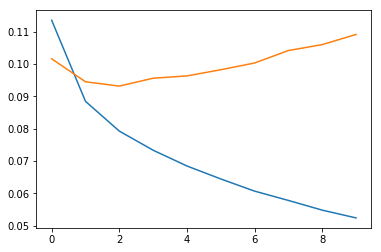

In [252]:
import matplotlib.pyplot as plt
#returns min train epoch and value
print(min(history.history['loss']), history.history['loss'].index(min(history.history['loss'])))
#returns minimum val epoch and value
print(min(history.history['val_loss']), history.history['val_loss'].index(min(history.history['val_loss'])))
plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
#Yellow=Validation set
#Blue= Training Set
#_=_

In [253]:
#SKIP: Save Model
from keras.models import load_model
model.save('model1.h5')

In [254]:
#Load Model with saved weights
model.load_weights("model1.h5")
print("Loaded model from disk")

Loaded model from disk


### Model Evaluation

Let's use accuracy to evaluate our model:

In [255]:
from sklearn.metrics import accuracy_score
h = model.predict([data['test']['text']])
#model total accuracy on test data
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(
    len(predict), resultf1
))

#show breakdown of accuracy
test = predict/gold
out=[]
for val in test:
    if(val==3/5):
        out.append("predict:3 actual:5")
    if(val==1/5):
        out.append("predict:1 actual:5")
    if(val==1/3):
        out.append("predict:1 actual:3")
    if(val==5/3):
        out.append("predict:5 actual:3")
    if(val==3/1):
        out.append("predict:3 actual:1")
    if(val==5/1):
        out.append("predict:5 actual:1")

missedNum=[]
for val in test:
    if(val==3/5 or val==1/5):
        missedNum.append(5)
    if(val==1/3 or val==5/3):
        missedNum.append(3)
    if(val==3/1 or val == 5/1):
        missedNum.append(1)
#equals the number of incorrect guesses for a specific num
missedNum = {i:missedNum.count(i) for i in missedNum}

#equals the number of incorrect guesses of a specific num for a specific num
incorrect = {i:out.count(i) for i in out}

actualNum= gold.tolist()
#equals the number of actual of each number
actualNum = {i:actualNum.count(i) for i in actualNum}
accuracy = []
print(incorrect)
print(missedNum)  
print(actualNum)
accuracy.append(missedNum.get(1)/actualNum.get(1))
accuracy.append(missedNum.get(3)/actualNum.get(3))
accuracy.append(missedNum.get(5)/actualNum.get(5))
accuracy= {1-i for i in accuracy}
print(accuracy)

Accuracy score on 333 test samples: 0.558559
{'predict:3 actual:5': 25, 'predict:1 actual:3': 37, 'predict:5 actual:3': 28, 'predict:5 actual:1': 18, 'predict:1 actual:5': 19, 'predict:3 actual:1': 20}
{5: 44, 3: 65, 1: 38}
{5: 103, 3: 118, 1: 112}
{0.6607142857142857, 0.4491525423728814, 0.5728155339805825}


### Inference

In [29]:
#Not using
#def infer(texts):
#    sequences = []
#    for text in texts:
#        text = text.split()
#        text_sequence = []
#        for word in text:
#            if word in vocabulary:
#                text_sequence.append(vocabulary[word])
#        sequences.append(text_sequence)

#    padded_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
#    return model.predict([padded_seq])
    
    

#h_ = infer(text)
#for i,t in enumerate(text):
#    print('{} {} {}'.format(
#            np.argmax(h_[i]),
#            h_[i],
#            t[:MAX_SEQUENCE_LENGTH],
#        ))


Implement a model similar to the one described in [this paper](https://arxiv.org/pdf/1704.06125.pdf), in order to get a much higher accuracy.

In [256]:
# # Analysis through CNN model
from keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Reshape, Dropout
from keras.models import Model
class BaselineModel2(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(
            shape=(MAX_SEQUENCE_LENGTH,),
            name='Input'
        )
        embedding_layer = layers.Embedding(len(vocabulary) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            name='Embedding',
                            trainable=False)(input_layer)

        conv1 = Conv1D(200, 2, activation='relu')(embedding_layer)
        conv2 = Conv1D(200, 3, activation='relu')(embedding_layer)
        conv3 = Conv1D(200, 4, activation='relu')(embedding_layer)
        
        pool1 = GlobalMaxPooling1D()(conv1)
        pool2 = GlobalMaxPooling1D()(conv2)
        pool3 = GlobalMaxPooling1D()(conv3)
        
        conc_layer = keras.layers.concatenate([pool3, pool2, pool1])
        drop1 = Dropout(0.5)(conc_layer)
        fc_layer1 = layers.Dense(units=30,name='FullyConnected')(drop1)
        drop2 = Dropout(0.5)(fc_layer1)
        #fc_layer2 = layers.Flatten(name="Flatten")(drop2)
        predictions = Dense(6, activation='softmax')(drop2)
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(
            optimizer=keras.optimizers.Adam(lr=0.001),
            loss='mse'
        )

In [257]:
#compile then train model NOT CROSS VALIDATION
#could train even longer
model2 = BaselineModel2()
model2.compile()
history = model2.fit(
    [data['train']['text']],
    keras.utils.to_categorical(data['train']['y'],0),
    epochs=10,
    verbose=0,
    callbacks=[
        TQDMNotebookCallback(
            leave_inner=True,
        )
    ],
    validation_data=(
        [data['val']['text']],
        keras.utils.to_categorical(data['val']['y'],0)
    ),
    batch_size=128
)

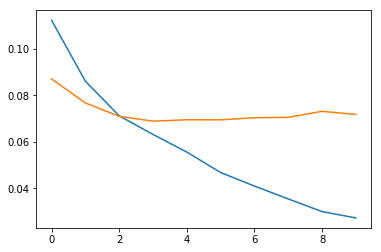

In [258]:
#show results of training and evaluation of model
import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
#_=_

In [210]:
#SKIP: Save Model
from keras.models import load_model
model2.save('model2.h5')

In [211]:
#Load Model with saved weights
model2.load_weights("model2.h5")
print("Loaded model from disk")

Loaded model from disk


In [259]:
#Evaluate MOdel

from sklearn.metrics import accuracy_score
h = model2.predict([data['test']['text']])
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(
    len(predict), resultf1
))
#show breakdown of accuracy
test = predict/gold
out=[]
for val in test:
    if(val==3/5):
        out.append("predict:3 actual:5")
    if(val==1/5):
        out.append("predict:1 actual:5")
    if(val==1/3):
        out.append("predict:1 actual:3")
    if(val==5/3):
        out.append("predict:5 actual:3")
    if(val==3/1):
        out.append("predict:3 actual:1")
    if(val==5/1):
        out.append("predict:5 actual:1")

missedNum=[]
for val in test:
    if(val==3/5 or val==1/5):
        missedNum.append(5)
    if(val==1/3 or val==5/3):
        missedNum.append(3)
    if(val==3/1 or val == 5/1):
        missedNum.append(1)
#equals the number of incorrect guesses for a specific num
missedNum = {i:missedNum.count(i) for i in missedNum}

#equals the number of incorrect guesses of a specific num for a specific num
incorrect = {i:out.count(i) for i in out}

actualNum= gold.tolist()
#equals the number of actual of each number
actualNum = {i:actualNum.count(i) for i in actualNum}
accuracy = []
print(incorrect)
print(missedNum)  
print(actualNum)
accuracy.append(missedNum.get(1)/actualNum.get(1))
accuracy.append(missedNum.get(3)/actualNum.get(3))
accuracy.append(missedNum.get(5)/actualNum.get(5))
accuracy= {1-i for i in accuracy}
print(accuracy)

Accuracy score on 333 test samples: 0.696697
{'predict:3 actual:5': 16, 'predict:1 actual:3': 18, 'predict:5 actual:3': 34, 'predict:5 actual:1': 11, 'predict:1 actual:5': 4, 'predict:3 actual:1': 18}
{5: 20, 3: 52, 1: 29}
{5: 103, 3: 118, 1: 112}
{0.7410714285714286, 0.5593220338983051, 0.8058252427184466}


In [260]:
#Schema create LTSM model
from keras.layers import Input, Dense, GlobalMaxPooling1D, Bidirectional, LSTM
from keras.models import Model


class BaselineModel3(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(
            shape=(MAX_SEQUENCE_LENGTH,),
            name='Input'
        )
        print(input_layer.shape)
        embedding_layer = layers.Embedding(len(vocabulary) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            name='Embedding',
                            trainable=False)(input_layer)
        print(embedding_layer.shape)
        drop1 = Dropout(0.5)(embedding_layer)
        bi_lay = Bidirectional(LSTM(200, return_sequences=False))(drop1)
        drop2 = Dropout(0.5)(bi_lay)
        print(drop2.shape)
        f_con = Dense(30, activation="sigmoid")(drop2)
        drop3 = Dropout(0.5)(f_con)
        print(drop3.shape)
        predictions = Dense(6, activation='softmax')(drop3)
        
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(
            optimizer=keras.optimizers.Adam(lr=0.001),
            loss='mse'
        )

In [265]:
#compile model
#Could train longer
model3 = BaselineModel3()
model3.compile()

#shape of training data
#print(data['train']['text'].shape)

#train model NOT CROSS VALIDATION
history = model3.fit([data['train']['text']],keras.utils.to_categorical(data['train']['y'],0),
                     epochs=25,verbose=0,callbacks=[TQDMNotebookCallback(leave_inner=True,)
    ],
    validation_data=(
        [data['val']['text']],
        keras.utils.to_categorical(data['val']['y'],0)
    ),
    batch_size=32
)

(?, 40)
(?, 40, 300)
(?, 400)
(?, 30)


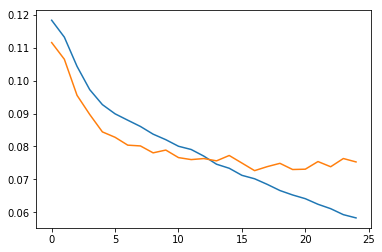

In [266]:
#Evaluate training model
import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
#_=_
#yellow= evaluation data

In [267]:
#SKIP: Save Model
from keras.models import load_model
model3.save('model3.h5')

In [268]:
#Load Model with saved weights
model3.load_weights("model3.h5")
print("Loaded model from disk")

Loaded model from disk


In [269]:
#Evaluate with test data

from sklearn.metrics import accuracy_score
h = model3.predict([data['test']['text']])
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(
    len(predict), resultf1
))

#show breakdown of accuracy
test = predict/gold
out=[]
for val in test:
    if(val==3/5):
        out.append("predict:3 actual:5")
    if(val==1/5):
        out.append("predict:1 actual:5")
    if(val==1/3):
        out.append("predict:1 actual:3")
    if(val==5/3):
        out.append("predict:5 actual:3")
    if(val==3/1):
        out.append("predict:3 actual:1")
    if(val==5/1):
        out.append("predict:5 actual:1")

missedNum=[]
for val in test:
    if(val==3/5 or val==1/5):
        missedNum.append(5)
    if(val==1/3 or val==5/3):
        missedNum.append(3)
    if(val==3/1 or val == 5/1):
        missedNum.append(1)
#equals the number of incorrect guesses for a specific num
missedNum = {i:missedNum.count(i) for i in missedNum}

#equals the number of incorrect guesses of a specific num for a specific num
incorrect = {i:out.count(i) for i in out}

actualNum= gold.tolist()
#equals the number of actual of each number
actualNum = {i:actualNum.count(i) for i in actualNum}
accuracy = []
print(incorrect)
print(missedNum)  
print(actualNum)
accuracy.append(missedNum.get(1)/actualNum.get(1))
accuracy.append(missedNum.get(3)/actualNum.get(3))
accuracy.append(missedNum.get(5)/actualNum.get(5))
accuracy= {1-i for i in accuracy}
print(accuracy)

Accuracy score on 333 test samples: 0.651652
{'predict:1 actual:5': 10, 'predict:1 actual:3': 33, 'predict:5 actual:3': 39, 'predict:5 actual:1': 11, 'predict:3 actual:1': 12, 'predict:3 actual:5': 11}
{5: 21, 3: 72, 1: 23}
{5: 103, 3: 118, 1: 112}
{0.7946428571428572, 0.38983050847457623, 0.7961165048543689}
